In [ ]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
from numba import njit, jit, prange
D_0 = 4.
D_R = 1e-12
L = 100
R = L/5
T = 600

array([ 1,  4,  9, 16, 25])

In [ ]:
@njit(fastmath=True)
def get_power(p, theta, t, phi):
    return p * (np.sin(2 * np.pi * t / theta  + phi) + 1)


@njit(fastmath=True)
def heat_step(
    cube_current,
    heater_size,
    heater_coordinates,
    dt,
    dx,
    power,
):
    x1 = int((heater_coordinates[0] - heater_size[0]) / dx)
    x2 = int((heater_coordinates[0] + heater_size[0]) / dx)
    y1 = int((heater_coordinates[1] - heater_size[1]) / dx)
    y2 = int((heater_coordinates[1] + heater_size[1]) / dx)
    z1 = int((heater_coordinates[2] - heater_size[2]) / dx)
    z2 = int((heater_coordinates[2] + heater_size[2]) / dx)
    cube_current[x1:x2+1, y1:y2+1, z1:z2+1] += power * dt


@njit(fastmath=True, parallel=True)
def diffusion_step(
    cube_current,
    cube_prev,
    graduations,
    sphere_coordinates,
    sphere_radius,
    dx,
    dt,
):
    diffuse_coeffs = np.full((graduations, graduations, graduations), D_0, dtype=np.float64)

    for x in prange(1, graduations-1):
      for y in prange(1, graduations-1):
        for z in prange(1, graduations-1):
          if(
              ((2 * x + 1) * dx / 2 - sphere_coordinates[0]) ** 2 +
              ((2 * y + 1) * dx / 2 - sphere_coordinates[1]) ** 2 +
              ((2 * z + 1) * dx / 2 - sphere_coordinates[2]) ** 2
          ) < (sphere_radius ** 2):
            diffuse_coeffs[x,y,z] = D_R

    g = dt * diffuse_coeffs / (dx**2)
    cube_current[1:-1, 1:-1, 1:-1] = (
      cube_prev[1:-1, 1:-1, 1:-1] +
      g[1:-1, 1:-1, 1:-1] * (
        cube_prev[2:, 1:-1, 1:-1] +
        cube_prev[:-2, 1:-1, 1:-1] +
        cube_prev[1:-1, 2: , 1:-1] +
        cube_prev[1:-1, :-2, 1:-1] +
        cube_prev[1:-1, 1:-1, 2:] +
        cube_prev[1:-1, 1:-1, :-2] -
        6 * cube_prev[1:-1, 1:-1, 1:-1]
        )
    )


@njit(fastmath=True)
def isolation(cube):
    cube[0,:,:] = 0.
    cube[:,-1,:] = 0.

    cube[-1,:,:] = cube[-2,:,:]
    cube[:,0,:] = cube[:,1,:]
    cube[:,:,-1] = cube[:,:,-2]
    cube[:,:,0] = cube[:,:,1]

@njit(fastmath=True)
def calculation(dx, dt):
    t = int(T)
    graduations = int(L / dx)

    heater_sizes = np.array([[4 / dx, 0.2 * L, 0.2 * L], [0.2 * L, 4 / dx, 0.2 * L]], dtype=np.float64)
    heater_coordinates = np.array([[0.2 * L, 0.5 * L, 0.5 * L], [0.5 * L, 0.2 * L, 0.5 * L]], dtype=np.float64)

    sphere_coordinates = np.array([L / 2., L / 2., L / 2.], dtype=np.float64)

    cube_prev = np.zeros((graduations, graduations, graduations), dtype=np.float64)
    cube_current = np.zeros((graduations, graduations, graduations), dtype=np.float64)

    probes = [
        (int((0.3 * L) / dx), int((0.3 * L) / dx), int((0.5 * L) / dx)),
        (int((0.3 * L) / dx), int((0.7 * L) / dx), int((0.5 * L) / dx)),
        (int((0.7 * L) / dx), int((0.7 * L) / dx), int((0.5 * L) / dx)),
        (int((0.7 * L) / dx), int((0.3 * L) / dx), int((0.5 * L) / dx))
    ]

    dots = np.zeros((4, int(t/dt)), dtype=np.float64)
    for it, tnow in enumerate(np.arange(dt, t + dt, dt, dtype=np.float64)):

        diffusion_step(cube_current, cube_prev, graduations, sphere_coordinates, 0.2 * L, dx, dt)
        isolation(cube_current)
        heat_step(cube_current, heater_sizes[0], heater_coordinates[0], dt, dx, get_power(100, 50, tnow, 0))
        heat_step(cube_current, heater_sizes[1], heater_coordinates[1], dt, dx, get_power(100, 77, tnow, 10))
        for i in range(4):
            dots[i][it] = cube_current[probes[i]]

        cube_prev, cube_current = cube_current, cube_prev
    return dots, cube_prev[:, :, int(0.5 * L / dx)]

<ipython-input-2-4994b87e8ac2>:94: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  diffusion_step(cube_current, cube_prev, graduations, sphere_coordinates, 0.2 * L, dx, dt)


for dx=4, dt=0.2 calculation takes 10.269872188568115
for dx=2, dt=0.1 calculation takes 7.481989860534668
for dx=1, dt=0.05 calculation takes 126.15091705322266


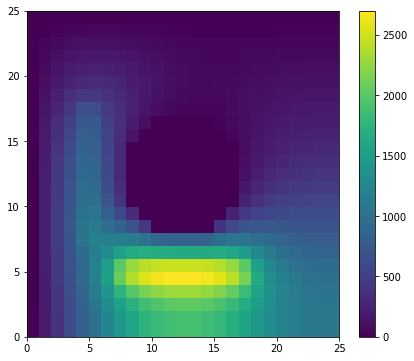

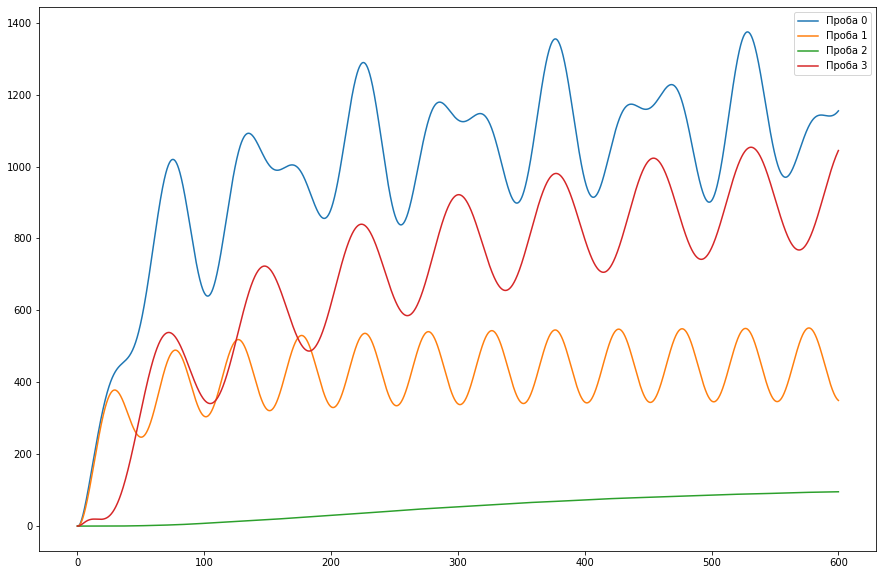

<Figure size 432x288 with 0 Axes>

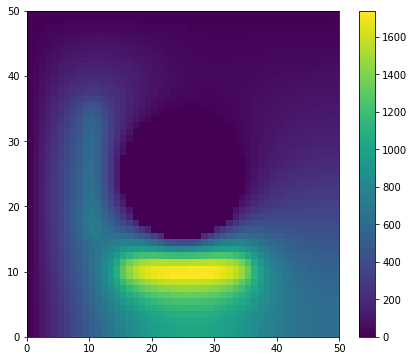

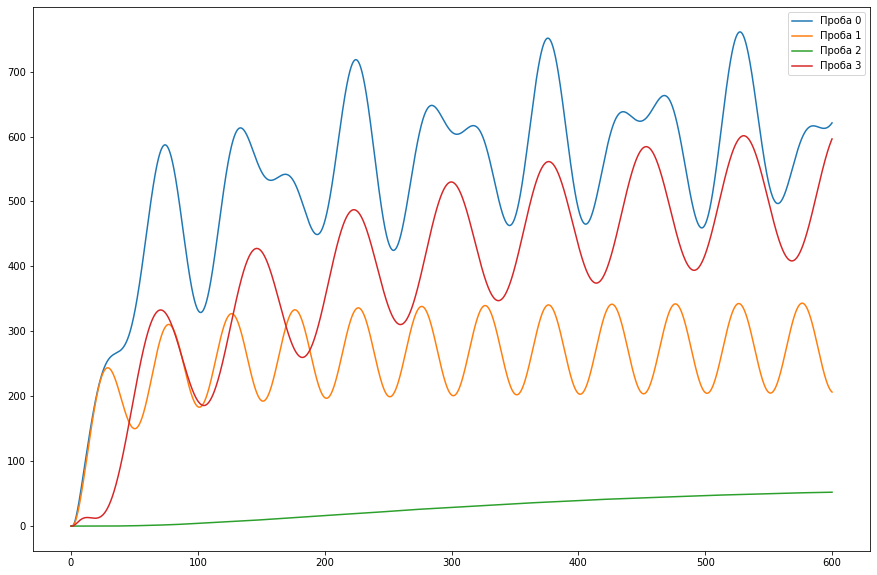

<Figure size 432x288 with 0 Axes>

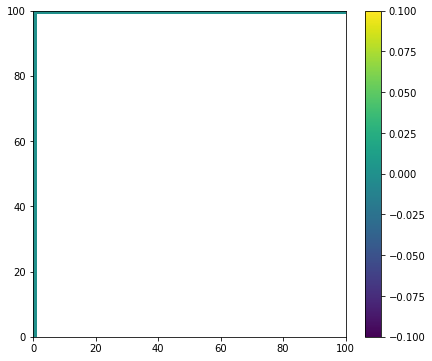

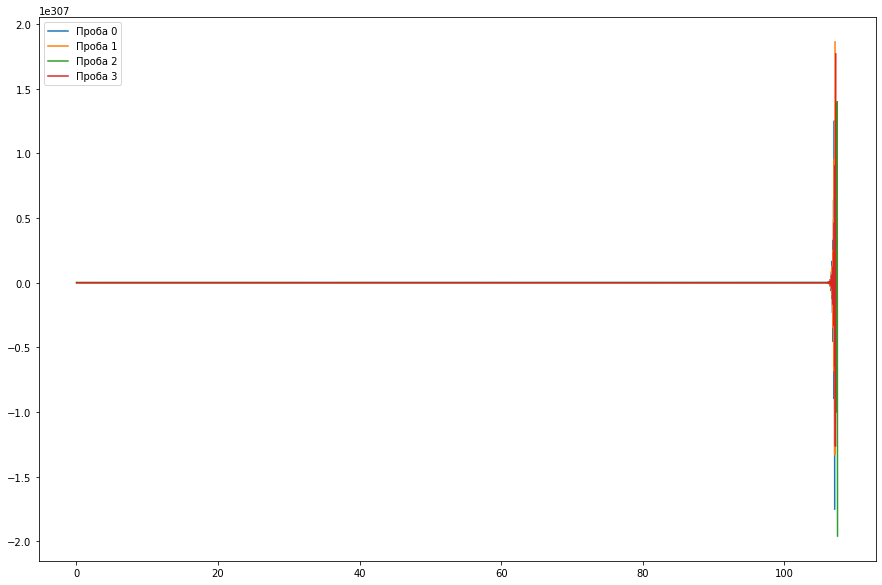

<Figure size 432x288 with 0 Axes>

In [ ]:
for (dx, dt) in [(4, 0.2), (2,0.1), (1, 0.05)]:
    x = np.arange(dt, T + 0.0001, dt, dtype=np.float64)
    start = time()
    T_dots, slice = calculation(dx, dt)
    print(f'for dx={dx}, dt={dt} calculation takes {time() - start}')
    plt.figure(figsize=(7, 6))
    plt.pcolormesh(np.transpose(slice))
    plt.colorbar()

    phig, ax = plt.subplots(figsize=(15,10))
    for i in range(4):
      ax.plot(x, T_dots[i], label='Проба ' + str(i))
    ax.legend()
    fig = plt.figure()
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()



